# Séries temporais exôgenas

## Importações e configurações iniciais

In [116]:
## Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import explained_variance_score

# models
from sklearn.linear_model import Ridge, LinearRegression, Lars, BayesianRidge, Perceptron, SGDRegressor
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV, LassoLarsCV, OrthogonalMatchingPursuit, ARDRegression
from sklearn.linear_model import PassiveAggressiveClassifier, TheilSenRegressor, HuberRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Estilos para os gráficos
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [87]:
df = pd.read_csv(PATH)
df.columns

Index(['date', 'DC_NOME', 'PRE_INS', 'TEM_SEN', 'VL_LATITUDE', 'PRE_MAX', 'UF',
       'RAD_GLO', 'PTO_INS', 'TEM_MIN', 'VL_LONGITUDE', 'UMD_MIN', 'PTO_MAX',
       'VEN_DIR', 'DT_MEDICAO', 'CHUVA', 'PRE_MIN', 'UMD_MAX', 'VEN_VEL',
       'PTO_MIN', 'TEM_MAX', 'VEN_RAJ', 'TEM_INS', 'UMD_INS', 'CD_ESTACAO',
       'HR_MEDICAO'],
      dtype='object')

## Preparação dos dados

In [90]:
# definindo caminho do arquivo
PATH = "data/df_20181s_20201s_A523.csv"

# escolhendo target
TARGET = "UMD_INS"

# incluindo novas features
FEATURES = ['TEM_INS', 'PRE_INS']

# definindo coluna de data
DATE_COLUMN = "date"

# Carregamento dos dados
df = pd.read_csv(PATH)

# Convertendo datas
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])

# Selecionando colunas
df = df[[DATE_COLUMN, TARGET] + FEATURES]

# Preenchendo nulos com a média
df = df.fillna(method="ffill")

# Escolha da granularidade (diária)
df = df[[DATE_COLUMN,TARGET] + FEATURES].groupby(DATE_COLUMN).mean()

# Renomeando coluna TARGET
df.columns = ['Y_t'] + FEATURES

# Normalizando
df['X_t'] = StandardScaler().fit_transform(df['Y_t'].values.reshape(-1, 1))
for feature in FEATURES:
    df[feature] = StandardScaler().fit_transform(df[feature].values.reshape(-1, 1))

# Determinando número de lags
LAGS = 5

# Criando LAGS
for i in range(LAGS):
    df[f"X_{i+1}"] = df.X_t.shift(i+1)
df = df.dropna()

# Separando features (X) e target (y)
X = df[[f"X_{i+1}" for i in range(LAGS)] + FEATURES]
y = df['X_t']

# Dividindo conjuntos de treino e teste
X_train = X.iloc[:1096] # 01-01-2018 até 31-12-2020
X_test = X.iloc[1096:] # 01-01-2021 até 30-06-2021
y_train = y.iloc[:1096] # 01-01-2018 até 31-12-2020
y_test = y.iloc[1096:] # 01-01-2021 até 30-06-2021

## EDA

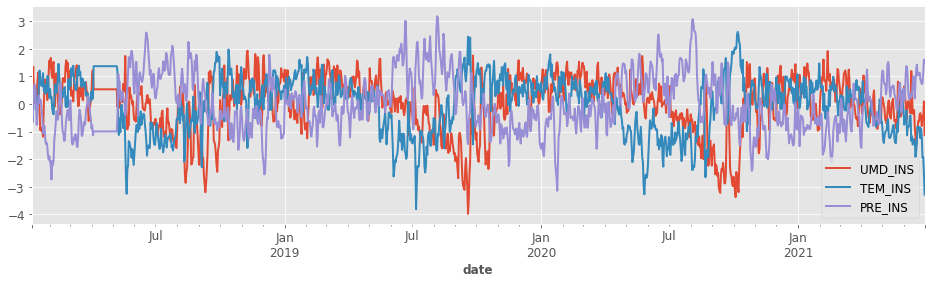

In [98]:
# X_t
df.X_t.plot(figsize=(16,4), label=TARGET)
for feature in FEATURES:
    df[feature].plot(label=feature)
plt.legend()
plt.show()

## Modelagem com Decision Tree Regressor

In [99]:
# Ajustando o modelo ao treino
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [100]:
# Calculando predições
y_pred = reg.predict(X_test)

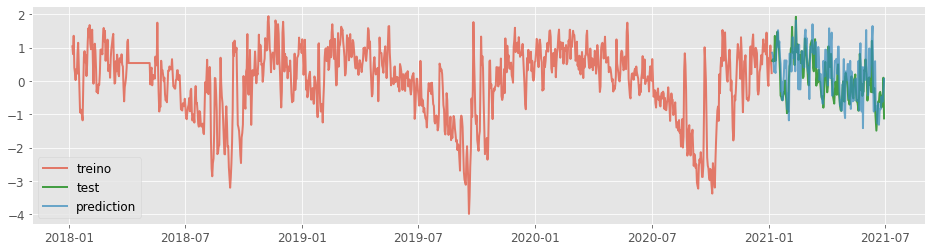

In [101]:
# Visualizando modelagem
plt.figure(figsize=(16,4))
plt.plot(y_train.index, y_train, alpha=0.7, label="treino")
plt.plot(y_test.index, y_test, alpha=0.7, color="g", label="test")
plt.plot(y_test.index, y_pred, alpha=0.7, label="prediction")
plt.legend()
plt.show()

In [102]:
# Avaliando o modelo com evs
explained_variance_score(y_test, y_pred)

0.2793670671642291

## Modelagem com Ridge

In [103]:
# Ajustando o modelo ao treino
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge()

In [104]:
# Calculando predições
y_pred = ridge.predict(X_test)

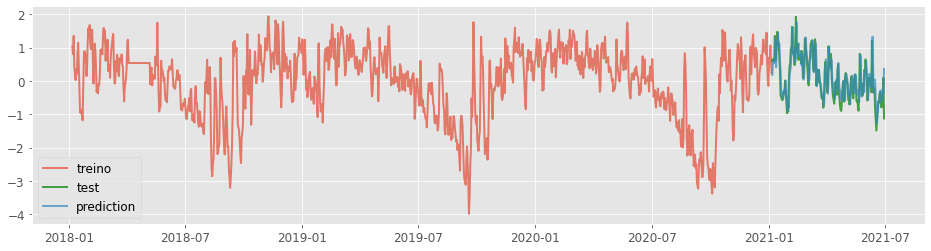

In [105]:
# Visualizando modelagem
plt.figure(figsize=(16,4))
plt.plot(y_train.index, y_train, alpha=0.7, label="treino")
plt.plot(y_test.index, y_test, alpha=0.7, color="g", label="test")
plt.plot(y_test.index, y_pred, alpha=0.7, label="prediction")
plt.legend()
plt.show()

In [106]:
# Avaliando o modelo com evs
explained_variance_score(y_test, y_pred)

0.631252372970732

## Pipeline completo

### Preparação dos dados

In [108]:
def prepar_dataframe(path, target, date_column, features, lags, train_size):
    df = pd.read_csv(path)
    df[date_column] = pd.to_datetime(df[date_column])
    df = df[[date_column, target] + features]
    df = df.fillna(method="ffill")
    df = df[[date_column,target] + features].groupby(date_column).mean()
    df.columns = ['Y_t'] + features
    df['X_t'] = StandardScaler().fit_transform(df['Y_t'].values.reshape(-1, 1))
    for feature in features:
        df[feature] = StandardScaler().fit_transform(df[feature].values.reshape(-1, 1))    
    for i in range(lags):
        df[f"X_{i+1}"] = df.X_t.shift(i+1)
    df = df.dropna()
    X = df[[f"X_{i+1}" for i in range(lags)] + features]
    y = df['X_t']
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    return X_train, X_test, y_train, y_test

In [109]:
PATH = "data/df_20181s_20201s_A523.csv"
TARGET = "UMD_INS"
DATE_COLUMN = "date"
LAGS = 5
TRAIN_SIZE = 1096
FEATURES = ['TEM_INS', 'PRE_INS']
X_train, X_test, y_train, y_test = prepar_dataframe(
    PATH, TARGET, DATE_COLUMN, FEATURES, LAGS, TRAIN_SIZE)

### Modelagem

In [111]:
def model_evs(X_train, X_test, y_train, y_test, model, model_params):
    reg = model(**model_params)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    return explained_variance_score(y_test, y_pred)

In [112]:
model_evs(X_train, X_test, y_train, y_test, Ridge, {"alpha": 1.0})

0.631252372970732

## Comparação de modelos

In [114]:
models = [
    Ridge, LinearRegression, Lars, BayesianRidge, SGDRegressor, 
    RidgeCV, ElasticNet, LassoCV, LassoLarsCV, OrthogonalMatchingPursuit, ARDRegression,
    TheilSenRegressor, HuberRegressor, ExtraTreeRegressor, DecisionTreeRegressor, LinearSVR, 
    NuSVR, SVR,  
    AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
]
models_labels = [model.__name__ for model in models]
models_params = [
    dict() for model in models
]

models_score = []

for i in range(len(models)):
    evs = model_evs(X_train, X_test, y_train, y_test, models[i], models_params[i])
    models_score.append(evs)

results = pd.DataFrame({
    "model": models_labels,
    "evs": models_score
})

In [115]:
results.sort_values("evs", ascending=False)

,model,evs
20,GradientBoostingRegressor,0.658714
17,SVR,0.654820
16,NuSVR,0.654665
21,RandomForestRegressor,0.641461
11,TheilSenRegressor,0.634191
8,LassoLarsCV,0.632014
7,LassoCV,0.631985
3,BayesianRidge,0.631397
0,Ridge,0.631252
5,RidgeCV,0.631252


## Referências

Tutoriais:
- https://www.youtube.com/watch?v=pxd4ZzROqtI&list=PL5fQ3JoS0SZscDaHgXahtx632NMnq5RR-
- https://www.youtube.com/watch?v=JuGUAvC5qs8&list=PLSDVadsSlXTCVcg95hQsEOVRnVwgaPTRC

Bibliotecas:
- https://www.statsmodels.org/
- https://scikit-learn.org/
- https://pandas.pydata.org/
- https://matplotlib.org/

Dados:
- https://tempo.inmet.gov.br/